In [49]:
import math
import numpy as np
from scipy.special import erfinv
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Neural Networks

In [2]:
class MLP_light(nn.Module):
    def __init__(self, N, p):
        super(MLP_light, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        output = self.fc3(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss
    
    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss

## Relative functions

In [3]:
class Generator_eye(object):
    def __init__(self, p, theta, beta_range) -> None:
        self.p = p 
        self.theta = theta 
        self.beta_range = beta_range 
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        scale = self.beta_range[1] - self.beta_range[0]
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.rand(np.sum(gamma == 1)) * scale + self.beta_range[0]
        beta[gamma == 0] = 0. 
        Y = beta@self.X.T + rng.randn(n, self.p)
        return gamma, beta, Y 

In [4]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n
             
def model_test(model, data_loader, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        n = 0 
        total_loss = 0.
        for _, (data, targ) in enumerate(data_loader):
            data, targ = data.to(device), targ.to(device)
            if loss_type == 'mse':
                loss = model.get_mseloss(data, targ)
            elif loss_type == 'bce':
                loss = model.get_bceloss(data, targ)
            elif loss_type == 'quantile':
                loss = model.get_quanloss(data, targ, q)
            total_loss += loss.item() * data.shape[0]
            n += data.shape[0]
    return total_loss/n

def train_model(model, model_es, lr, epochs, train_data, loss_type='mse', q=0.5, val_data=None, early_stop=5):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    es_flag = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if (es_count >= early_stop) and (es_flag == 0):
                es_flag = 1
                print('Save early stopping model at epoch {}'.format(i+1))
                model_es.load_state_dict(deepcopy(model.state_dict()))
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [5]:
''' 
compute normalization constant
'''
def compute_c(y, theta, a, sigma):
    c = 2*a * (1-theta) * np.exp(-y**2 / (2 * sigma**2)) \
    + theta * np.sqrt(np.pi/2) * sigma * \
    (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-a)/(sigma*np.sqrt(2))))
    return c / (2*a)

In [6]:
''' 
compute the cumulative probablity of the marginal distribution of beta
'''
def cumulative_prob(t, y, norm_c, theta, a, sigma):
    assert t>=-a and t<=a
    if t>=0:
        prob = (1-theta) * np.exp(-y**2 / (2 * sigma**2)) / norm_c \
            + theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    elif t<0:
        prob = theta * np.sqrt(np.pi/2) * sigma * \
                (math.erf((y+a)/(sigma*np.sqrt(2))) - math.erf((y-t)/(sigma*np.sqrt(2)))) / (2 * a * norm_c)
    return prob

In [7]:
def computeQuantile(y, norm_c, theta, a, sigma, q=0.975):
    inner = ((1-theta) / norm_c * np.exp(-y**2 / (2 * sigma**2)) - q) \
        / (theta / (2*a*norm_c) * np.sqrt(np.pi/2) * sigma) + math.erf((y+a)/(sigma*np.sqrt(2)))
    t = y - np.sqrt(2) * sigma * erfinv(inner)
    return t 
def computePPI(y, theta, a, sigma):
    q025 = q975 = 0
    c = compute_c(y, theta, a, sigma)
    abs_y = np.abs(y)
    if abs_y >= 1.68:
        q975 = computeQuantile(abs_y, c, theta, a, sigma, 0.975)
    if abs_y >= 4.168:
        q025 = computeQuantile(abs_y, c, theta, a, sigma, 0.025)
    if y < 0:
        temp = q025
        q025 = -q975
        q975 = -temp 
    return q025, q975
def computePosMean(y, theta, a, sigma):
    c = compute_c(y, theta, a, sigma)
    left = sigma**2 * (np.exp(-((-a-y)/np.sqrt(2)/sigma)**2) - np.exp(-((a-y)/np.sqrt(2)/sigma)**2))
    right = np.sqrt(np.pi/2) * sigma * y * \
        (math.erf((a-y)/(sigma*np.sqrt(2))) - math.erf((-a-y)/(sigma*np.sqrt(2))))
    mu = theta / (2*a*c) * (left + right)
    return mu 

In [8]:
def compute_mses(md_mean, md_q025, md_q975, Y, Y_normalized, theta, a, sigma):
    true_mean = np.zeros_like(Y)
    true_q025 = np.zeros_like(Y)
    true_q975 = np.zeros_like(Y)
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            true_mean[i,j] = computePosMean(Y[i,j], theta, a, sigma)
            true_q025[i,j], true_q975[i,j] = computePPI(Y[i,j], theta, a, sigma)
    pred_mean = predict(md_mean, Y_normalized)
    pred_q025 = predict(md_q025, Y_normalized)
    pred_q975 = predict(md_q975, Y_normalized)
    mse_mean = np.mean((pred_mean-true_mean)**2)
    mse_q025 = np.mean((pred_q025-true_q025)**2)
    mse_q975 = np.mean((pred_q975-true_q975)**2)
    return mse_mean, mse_q025, mse_q975

## Experiments

Epoch: 1
Train loss: 0.13060
Val loss: 0.11444
Epoch: 2
Train loss: 0.11178
Val loss: 0.11292
Epoch: 3
Train loss: 0.10975
Val loss: 0.11032
Epoch: 4
Train loss: 0.10871
Val loss: 0.11099
Epoch: 5
Train loss: 0.10807
Val loss: 0.11024
Epoch: 6
Train loss: 0.10747
Val loss: 0.10933
Epoch: 7
Train loss: 0.10712
Val loss: 0.11038
Epoch: 8
Train loss: 0.10688
Val loss: 0.10960
Epoch: 9
Train loss: 0.10662
Val loss: 0.10894
Epoch: 10
Train loss: 0.10627
Val loss: 0.10905
Epoch: 11
Train loss: 0.10619
Val loss: 0.10835
Epoch: 12
Train loss: 0.10595
Val loss: 0.10907
Epoch: 13
Train loss: 0.10576
Val loss: 0.10789
Epoch: 14
Train loss: 0.10565
Val loss: 0.10702
Epoch: 15
Train loss: 0.10549
Val loss: 0.10897
Epoch: 16
Train loss: 0.10536
Val loss: 0.10906
Epoch: 17
Train loss: 0.10518
Val loss: 0.10867
Epoch: 18
Train loss: 0.10515
Val loss: 0.10863
Epoch: 19
Train loss: 0.10500
Val loss: 0.10780
Save early stopping model at epoch 19
Epoch: 20
Train loss: 0.10492
Val loss: 0.10917
Epoch: 21
T

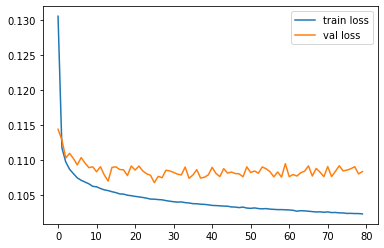

Epoch: 1
Train loss: 0.01444
Val loss: 0.01260
Epoch: 2
Train loss: 0.01192
Val loss: 0.01237
Epoch: 3
Train loss: 0.01163
Val loss: 0.01179
Epoch: 4
Train loss: 0.01150
Val loss: 0.01158
Epoch: 5
Train loss: 0.01139
Val loss: 0.01164
Epoch: 6
Train loss: 0.01131
Val loss: 0.01150
Epoch: 7
Train loss: 0.01124
Val loss: 0.01160
Epoch: 8
Train loss: 0.01117
Val loss: 0.01144
Epoch: 9
Train loss: 0.01114
Val loss: 0.01155
Epoch: 10
Train loss: 0.01110
Val loss: 0.01131
Epoch: 11
Train loss: 0.01105
Val loss: 0.01134
Epoch: 12
Train loss: 0.01102
Val loss: 0.01147
Epoch: 13
Train loss: 0.01100
Val loss: 0.01139
Epoch: 14
Train loss: 0.01099
Val loss: 0.01128
Epoch: 15
Train loss: 0.01097
Val loss: 0.01131
Epoch: 16
Train loss: 0.01096
Val loss: 0.01125
Epoch: 17
Train loss: 0.01094
Val loss: 0.01129
Epoch: 18
Train loss: 0.01093
Val loss: 0.01137
Epoch: 19
Train loss: 0.01092
Val loss: 0.01135
Epoch: 20
Train loss: 0.01091
Val loss: 0.01120
Epoch: 21
Train loss: 0.01091
Val loss: 0.01142
E

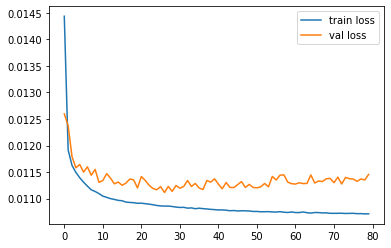

Epoch: 1
Train loss: 0.01431
Val loss: 0.01228
Epoch: 2
Train loss: 0.01175
Val loss: 0.01193
Epoch: 3
Train loss: 0.01145
Val loss: 0.01185
Epoch: 4
Train loss: 0.01130
Val loss: 0.01174
Epoch: 5
Train loss: 0.01117
Val loss: 0.01148
Epoch: 6
Train loss: 0.01109
Val loss: 0.01141
Epoch: 7
Train loss: 0.01102
Val loss: 0.01125
Epoch: 8
Train loss: 0.01096
Val loss: 0.01130
Epoch: 9
Train loss: 0.01091
Val loss: 0.01135
Epoch: 10
Train loss: 0.01087
Val loss: 0.01132
Epoch: 11
Train loss: 0.01085
Val loss: 0.01136
Epoch: 12
Train loss: 0.01083
Val loss: 0.01112
Epoch: 13
Train loss: 0.01081
Val loss: 0.01122
Epoch: 14
Train loss: 0.01079
Val loss: 0.01114
Epoch: 15
Train loss: 0.01078
Val loss: 0.01120
Epoch: 16
Train loss: 0.01077
Val loss: 0.01124
Epoch: 17
Train loss: 0.01075
Val loss: 0.01111
Epoch: 18
Train loss: 0.01074
Val loss: 0.01110
Epoch: 19
Train loss: 0.01073
Val loss: 0.01116
Epoch: 20
Train loss: 0.01072
Val loss: 0.01116
Epoch: 21
Train loss: 0.01071
Val loss: 0.01128
E

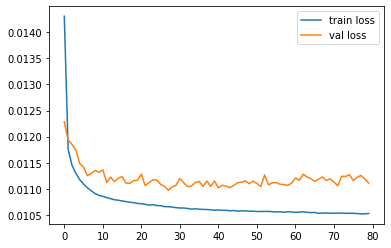

Epoch: 1
Train loss: 0.14107
Val loss: 0.11487
Epoch: 2
Train loss: 0.11355
Val loss: 0.11125
Epoch: 3
Train loss: 0.11125
Val loss: 0.11010
Epoch: 4
Train loss: 0.11011
Val loss: 0.10955
Epoch: 5
Train loss: 0.10940
Val loss: 0.10898
Epoch: 6
Train loss: 0.10883
Val loss: 0.10898
Epoch: 7
Train loss: 0.10848
Val loss: 0.10873
Epoch: 8
Train loss: 0.10812
Val loss: 0.10758
Epoch: 9
Train loss: 0.10786
Val loss: 0.10846
Epoch: 10
Train loss: 0.10750
Val loss: 0.10845
Epoch: 11
Train loss: 0.10730
Val loss: 0.10777
Epoch: 12
Train loss: 0.10704
Val loss: 0.10755
Epoch: 13
Train loss: 0.10682
Val loss: 0.10728
Epoch: 14
Train loss: 0.10664
Val loss: 0.10878
Epoch: 15
Train loss: 0.10646
Val loss: 0.10882
Epoch: 16
Train loss: 0.10628
Val loss: 0.10790
Epoch: 17
Train loss: 0.10612
Val loss: 0.10883
Epoch: 18
Train loss: 0.10591
Val loss: 0.10882
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.10578
Val loss: 0.10881
Epoch: 20
Train loss: 0.10569
Val loss: 0.10874
Epoch: 21
T

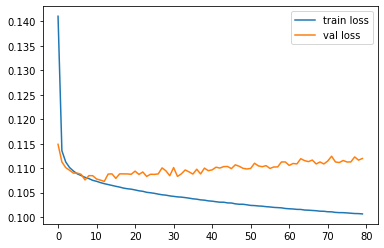

Epoch: 1
Train loss: 0.01619
Val loss: 0.01364
Epoch: 2
Train loss: 0.01351
Val loss: 0.01307
Epoch: 3
Train loss: 0.01308
Val loss: 0.01309
Epoch: 4
Train loss: 0.01290
Val loss: 0.01260
Epoch: 5
Train loss: 0.01278
Val loss: 0.01256
Epoch: 6
Train loss: 0.01268
Val loss: 0.01242
Epoch: 7
Train loss: 0.01261
Val loss: 0.01244
Epoch: 8
Train loss: 0.01256
Val loss: 0.01235
Epoch: 9
Train loss: 0.01253
Val loss: 0.01250
Epoch: 10
Train loss: 0.01248
Val loss: 0.01235
Epoch: 11
Train loss: 0.01245
Val loss: 0.01241
Epoch: 12
Train loss: 0.01242
Val loss: 0.01230
Epoch: 13
Train loss: 0.01239
Val loss: 0.01229
Epoch: 14
Train loss: 0.01236
Val loss: 0.01248
Epoch: 15
Train loss: 0.01233
Val loss: 0.01233
Epoch: 16
Train loss: 0.01230
Val loss: 0.01233
Epoch: 17
Train loss: 0.01227
Val loss: 0.01229
Epoch: 18
Train loss: 0.01225
Val loss: 0.01223
Epoch: 19
Train loss: 0.01223
Val loss: 0.01240
Epoch: 20
Train loss: 0.01221
Val loss: 0.01231
Epoch: 21
Train loss: 0.01220
Val loss: 0.01229
E

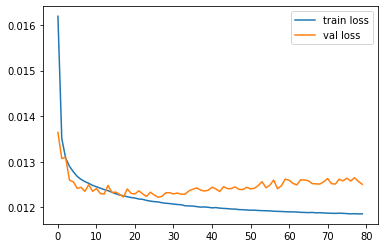

Epoch: 1
Train loss: 0.01628
Val loss: 0.01382
Epoch: 2
Train loss: 0.01353
Val loss: 0.01330
Epoch: 3
Train loss: 0.01312
Val loss: 0.01302
Epoch: 4
Train loss: 0.01296
Val loss: 0.01284
Epoch: 5
Train loss: 0.01285
Val loss: 0.01289
Epoch: 6
Train loss: 0.01277
Val loss: 0.01283
Epoch: 7
Train loss: 0.01270
Val loss: 0.01284
Epoch: 8
Train loss: 0.01264
Val loss: 0.01284
Epoch: 9
Train loss: 0.01259
Val loss: 0.01291
Epoch: 10
Train loss: 0.01255
Val loss: 0.01273
Epoch: 11
Train loss: 0.01252
Val loss: 0.01277
Epoch: 12
Train loss: 0.01248
Val loss: 0.01271
Epoch: 13
Train loss: 0.01245
Val loss: 0.01279
Epoch: 14
Train loss: 0.01241
Val loss: 0.01273
Epoch: 15
Train loss: 0.01238
Val loss: 0.01275
Epoch: 16
Train loss: 0.01236
Val loss: 0.01262
Epoch: 17
Train loss: 0.01233
Val loss: 0.01270
Epoch: 18
Train loss: 0.01231
Val loss: 0.01270
Epoch: 19
Train loss: 0.01229
Val loss: 0.01266
Epoch: 20
Train loss: 0.01229
Val loss: 0.01262
Epoch: 21
Train loss: 0.01226
Val loss: 0.01269
E

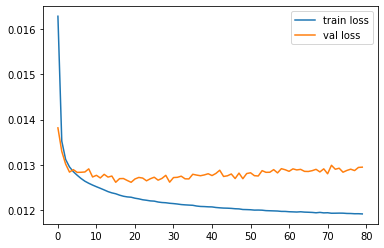

Epoch: 1
Train loss: 0.20050
Val loss: 0.13027
Epoch: 2
Train loss: 0.12469
Val loss: 0.12179
Epoch: 3
Train loss: 0.11917
Val loss: 0.12023
Epoch: 4
Train loss: 0.11680
Val loss: 0.11991
Epoch: 5
Train loss: 0.11534
Val loss: 0.11829
Epoch: 6
Train loss: 0.11433
Val loss: 0.11815
Epoch: 7
Train loss: 0.11358
Val loss: 0.11847
Epoch: 8
Train loss: 0.11299
Val loss: 0.11802
Epoch: 9
Train loss: 0.11255
Val loss: 0.11820
Epoch: 10
Train loss: 0.11211
Val loss: 0.11811
Epoch: 11
Train loss: 0.11177
Val loss: 0.11768
Epoch: 12
Train loss: 0.11144
Val loss: 0.11782
Epoch: 13
Train loss: 0.11115
Val loss: 0.11749
Epoch: 14
Train loss: 0.11090
Val loss: 0.11927
Epoch: 15
Train loss: 0.11065
Val loss: 0.11752
Epoch: 16
Train loss: 0.11038
Val loss: 0.11753
Epoch: 17
Train loss: 0.11023
Val loss: 0.11746
Epoch: 18
Train loss: 0.11006
Val loss: 0.11820
Epoch: 19
Train loss: 0.10988
Val loss: 0.11826
Epoch: 20
Train loss: 0.10969
Val loss: 0.11823
Epoch: 21
Train loss: 0.10956
Val loss: 0.11821
E

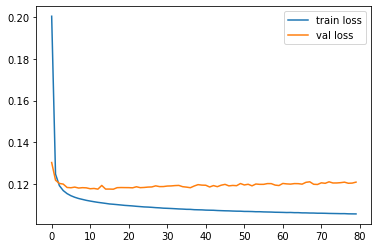

Epoch: 1
Train loss: 0.01983
Val loss: 0.01555
Epoch: 2
Train loss: 0.01471
Val loss: 0.01474
Epoch: 3
Train loss: 0.01399
Val loss: 0.01438
Epoch: 4
Train loss: 0.01371
Val loss: 0.01415
Epoch: 5
Train loss: 0.01354
Val loss: 0.01412
Epoch: 6
Train loss: 0.01341
Val loss: 0.01403
Epoch: 7
Train loss: 0.01330
Val loss: 0.01390
Epoch: 8
Train loss: 0.01322
Val loss: 0.01395
Epoch: 9
Train loss: 0.01316
Val loss: 0.01388
Epoch: 10
Train loss: 0.01310
Val loss: 0.01386
Epoch: 11
Train loss: 0.01305
Val loss: 0.01386
Epoch: 12
Train loss: 0.01300
Val loss: 0.01386
Epoch: 13
Train loss: 0.01295
Val loss: 0.01384
Epoch: 14
Train loss: 0.01291
Val loss: 0.01381
Epoch: 15
Train loss: 0.01288
Val loss: 0.01373
Epoch: 16
Train loss: 0.01285
Val loss: 0.01382
Epoch: 17
Train loss: 0.01282
Val loss: 0.01392
Epoch: 18
Train loss: 0.01280
Val loss: 0.01382
Epoch: 19
Train loss: 0.01277
Val loss: 0.01387
Epoch: 20
Train loss: 0.01275
Val loss: 0.01384
Save early stopping model at epoch 20
Epoch: 21
T

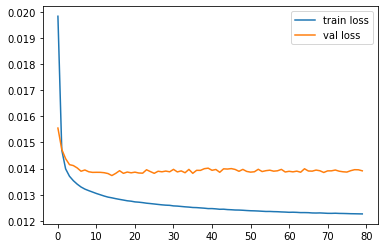

Epoch: 1
Train loss: 0.01986
Val loss: 0.01529
Epoch: 2
Train loss: 0.01480
Val loss: 0.01444
Epoch: 3
Train loss: 0.01402
Val loss: 0.01404
Epoch: 4
Train loss: 0.01371
Val loss: 0.01399
Epoch: 5
Train loss: 0.01356
Val loss: 0.01386
Epoch: 6
Train loss: 0.01343
Val loss: 0.01373
Epoch: 7
Train loss: 0.01334
Val loss: 0.01371
Epoch: 8
Train loss: 0.01325
Val loss: 0.01376
Epoch: 9
Train loss: 0.01319
Val loss: 0.01368
Epoch: 10
Train loss: 0.01313
Val loss: 0.01367
Epoch: 11
Train loss: 0.01308
Val loss: 0.01364
Epoch: 12
Train loss: 0.01303
Val loss: 0.01364
Epoch: 13
Train loss: 0.01298
Val loss: 0.01361
Epoch: 14
Train loss: 0.01295
Val loss: 0.01357
Epoch: 15
Train loss: 0.01292
Val loss: 0.01365
Epoch: 16
Train loss: 0.01290
Val loss: 0.01357
Epoch: 17
Train loss: 0.01287
Val loss: 0.01363
Epoch: 18
Train loss: 0.01285
Val loss: 0.01363
Epoch: 19
Train loss: 0.01283
Val loss: 0.01356
Epoch: 20
Train loss: 0.01281
Val loss: 0.01366
Epoch: 21
Train loss: 0.01279
Val loss: 0.01374
E

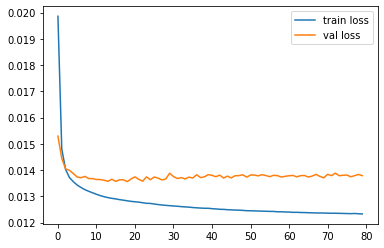

Epoch: 1
Train loss: 0.28356
Val loss: 0.14624
Epoch: 2
Train loss: 0.13859
Val loss: 0.13255
Epoch: 3
Train loss: 0.12870
Val loss: 0.12691
Epoch: 4
Train loss: 0.12419
Val loss: 0.12488
Epoch: 5
Train loss: 0.12165
Val loss: 0.12341
Epoch: 6
Train loss: 0.11993
Val loss: 0.12180
Epoch: 7
Train loss: 0.11872
Val loss: 0.12132
Epoch: 8
Train loss: 0.11779
Val loss: 0.12169
Epoch: 9
Train loss: 0.11706
Val loss: 0.12067
Epoch: 10
Train loss: 0.11640
Val loss: 0.12051
Epoch: 11
Train loss: 0.11590
Val loss: 0.12013
Epoch: 12
Train loss: 0.11543
Val loss: 0.11998
Epoch: 13
Train loss: 0.11502
Val loss: 0.11956
Epoch: 14
Train loss: 0.11465
Val loss: 0.11952
Epoch: 15
Train loss: 0.11428
Val loss: 0.11997
Epoch: 16
Train loss: 0.11391
Val loss: 0.11959
Epoch: 17
Train loss: 0.11359
Val loss: 0.11890
Epoch: 18
Train loss: 0.11325
Val loss: 0.11886
Epoch: 19
Train loss: 0.11299
Val loss: 0.11871
Epoch: 20
Train loss: 0.11272
Val loss: 0.11846
Epoch: 21
Train loss: 0.11242
Val loss: 0.11925
E

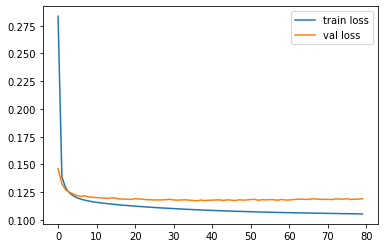

Epoch: 1
Train loss: 0.02373
Val loss: 0.01582
Epoch: 2
Train loss: 0.01544
Val loss: 0.01527
Epoch: 3
Train loss: 0.01490
Val loss: 0.01479
Epoch: 4
Train loss: 0.01450
Val loss: 0.01443
Epoch: 5
Train loss: 0.01422
Val loss: 0.01430
Epoch: 6
Train loss: 0.01400
Val loss: 0.01426
Epoch: 7
Train loss: 0.01384
Val loss: 0.01414
Epoch: 8
Train loss: 0.01365
Val loss: 0.01390
Epoch: 9
Train loss: 0.01349
Val loss: 0.01382
Epoch: 10
Train loss: 0.01338
Val loss: 0.01370
Epoch: 11
Train loss: 0.01331
Val loss: 0.01374
Epoch: 12
Train loss: 0.01326
Val loss: 0.01375
Epoch: 13
Train loss: 0.01322
Val loss: 0.01370
Epoch: 14
Train loss: 0.01317
Val loss: 0.01373
Epoch: 15
Train loss: 0.01313
Val loss: 0.01372
Epoch: 16
Train loss: 0.01310
Val loss: 0.01378
Epoch: 17
Train loss: 0.01308
Val loss: 0.01371
Epoch: 18
Train loss: 0.01304
Val loss: 0.01371
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.01301
Val loss: 0.01367
Epoch: 20
Train loss: 0.01299
Val loss: 0.01372
Epoch: 21
T

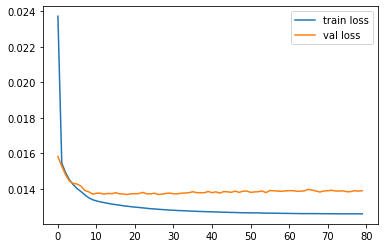

Epoch: 1
Train loss: 0.02391
Val loss: 0.01606
Epoch: 2
Train loss: 0.01540
Val loss: 0.01536
Epoch: 3
Train loss: 0.01490
Val loss: 0.01506
Epoch: 4
Train loss: 0.01456
Val loss: 0.01484
Epoch: 5
Train loss: 0.01429
Val loss: 0.01459
Epoch: 6
Train loss: 0.01404
Val loss: 0.01453
Epoch: 7
Train loss: 0.01380
Val loss: 0.01426
Epoch: 8
Train loss: 0.01358
Val loss: 0.01413
Epoch: 9
Train loss: 0.01342
Val loss: 0.01395
Epoch: 10
Train loss: 0.01330
Val loss: 0.01386
Epoch: 11
Train loss: 0.01322
Val loss: 0.01392
Epoch: 12
Train loss: 0.01317
Val loss: 0.01383
Epoch: 13
Train loss: 0.01312
Val loss: 0.01389
Epoch: 14
Train loss: 0.01308
Val loss: 0.01394
Epoch: 15
Train loss: 0.01305
Val loss: 0.01392
Epoch: 16
Train loss: 0.01302
Val loss: 0.01383
Epoch: 17
Train loss: 0.01299
Val loss: 0.01392
Epoch: 18
Train loss: 0.01296
Val loss: 0.01386
Epoch: 19
Train loss: 0.01293
Val loss: 0.01387
Epoch: 20
Train loss: 0.01291
Val loss: 0.01391
Epoch: 21
Train loss: 0.01288
Val loss: 0.01385
S

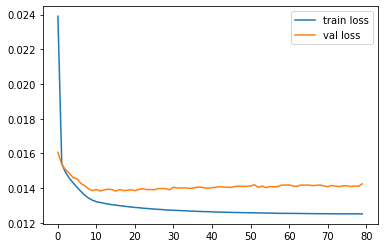

Epoch: 1
Train loss: 0.33915
Val loss: 0.15507
Epoch: 2
Train loss: 0.14437
Val loss: 0.14036
Epoch: 3
Train loss: 0.13274
Val loss: 0.13283
Epoch: 4
Train loss: 0.12736
Val loss: 0.13030
Epoch: 5
Train loss: 0.12466
Val loss: 0.12864
Epoch: 6
Train loss: 0.12283
Val loss: 0.12693
Epoch: 7
Train loss: 0.12146
Val loss: 0.12690
Epoch: 8
Train loss: 0.12046
Val loss: 0.12530
Epoch: 9
Train loss: 0.11965
Val loss: 0.12497
Epoch: 10
Train loss: 0.11887
Val loss: 0.12442
Epoch: 11
Train loss: 0.11829
Val loss: 0.12470
Epoch: 12
Train loss: 0.11776
Val loss: 0.12338
Epoch: 13
Train loss: 0.11729
Val loss: 0.12362
Epoch: 14
Train loss: 0.11684
Val loss: 0.12313
Epoch: 15
Train loss: 0.11641
Val loss: 0.12284
Epoch: 16
Train loss: 0.11601
Val loss: 0.12281
Epoch: 17
Train loss: 0.11562
Val loss: 0.12206
Epoch: 18
Train loss: 0.11524
Val loss: 0.12208
Epoch: 19
Train loss: 0.11489
Val loss: 0.12149
Epoch: 20
Train loss: 0.11455
Val loss: 0.12178
Epoch: 21
Train loss: 0.11428
Val loss: 0.12196
E

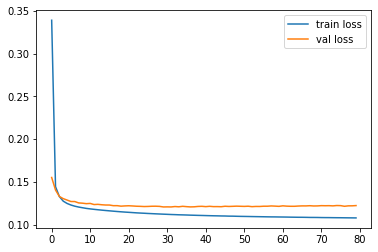

Epoch: 1
Train loss: 0.02651
Val loss: 0.01728
Epoch: 2
Train loss: 0.01634
Val loss: 0.01588
Epoch: 3
Train loss: 0.01495
Val loss: 0.01456
Epoch: 4
Train loss: 0.01413
Val loss: 0.01413
Epoch: 5
Train loss: 0.01384
Val loss: 0.01389
Epoch: 6
Train loss: 0.01368
Val loss: 0.01384
Epoch: 7
Train loss: 0.01359
Val loss: 0.01375
Epoch: 8
Train loss: 0.01350
Val loss: 0.01375
Epoch: 9
Train loss: 0.01344
Val loss: 0.01371
Epoch: 10
Train loss: 0.01338
Val loss: 0.01364
Epoch: 11
Train loss: 0.01333
Val loss: 0.01369
Epoch: 12
Train loss: 0.01328
Val loss: 0.01371
Epoch: 13
Train loss: 0.01324
Val loss: 0.01370
Epoch: 14
Train loss: 0.01321
Val loss: 0.01367
Epoch: 15
Train loss: 0.01317
Val loss: 0.01370
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01313
Val loss: 0.01367
Epoch: 17
Train loss: 0.01311
Val loss: 0.01368
Epoch: 18
Train loss: 0.01308
Val loss: 0.01366
Epoch: 19
Train loss: 0.01306
Val loss: 0.01364
Epoch: 20
Train loss: 0.01304
Val loss: 0.01373
Epoch: 21
T

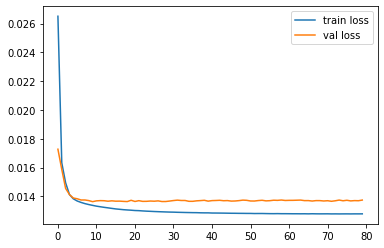

Epoch: 1
Train loss: 0.02628
Val loss: 0.01692
Epoch: 2
Train loss: 0.01583
Val loss: 0.01537
Epoch: 3
Train loss: 0.01476
Val loss: 0.01466
Epoch: 4
Train loss: 0.01416
Val loss: 0.01429
Epoch: 5
Train loss: 0.01386
Val loss: 0.01415
Epoch: 6
Train loss: 0.01372
Val loss: 0.01401
Epoch: 7
Train loss: 0.01363
Val loss: 0.01399
Epoch: 8
Train loss: 0.01356
Val loss: 0.01389
Epoch: 9
Train loss: 0.01349
Val loss: 0.01399
Epoch: 10
Train loss: 0.01342
Val loss: 0.01389
Epoch: 11
Train loss: 0.01337
Val loss: 0.01391
Epoch: 12
Train loss: 0.01332
Val loss: 0.01396
Epoch: 13
Train loss: 0.01328
Val loss: 0.01398
Epoch: 14
Train loss: 0.01325
Val loss: 0.01401
Epoch: 15
Train loss: 0.01322
Val loss: 0.01394
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01319
Val loss: 0.01395
Epoch: 17
Train loss: 0.01316
Val loss: 0.01398
Epoch: 18
Train loss: 0.01313
Val loss: 0.01394
Epoch: 19
Train loss: 0.01311
Val loss: 0.01395
Epoch: 20
Train loss: 0.01309
Val loss: 0.01397
Epoch: 21
T

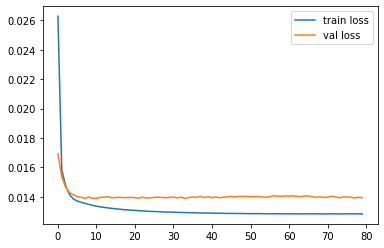

Epoch: 1
Train loss: 0.42083
Val loss: 0.16518
Epoch: 2
Train loss: 0.15134
Val loss: 0.14498
Epoch: 3
Train loss: 0.14041
Val loss: 0.13648
Epoch: 4
Train loss: 0.13291
Val loss: 0.13101
Epoch: 5
Train loss: 0.12862
Val loss: 0.12832
Epoch: 6
Train loss: 0.12604
Val loss: 0.12603
Epoch: 7
Train loss: 0.12420
Val loss: 0.12508
Epoch: 8
Train loss: 0.12287
Val loss: 0.12358
Epoch: 9
Train loss: 0.12168
Val loss: 0.12281
Epoch: 10
Train loss: 0.12073
Val loss: 0.12208
Epoch: 11
Train loss: 0.11990
Val loss: 0.12140
Epoch: 12
Train loss: 0.11911
Val loss: 0.12090
Epoch: 13
Train loss: 0.11845
Val loss: 0.12006
Epoch: 14
Train loss: 0.11781
Val loss: 0.11981
Epoch: 15
Train loss: 0.11727
Val loss: 0.11950
Epoch: 16
Train loss: 0.11682
Val loss: 0.11934
Epoch: 17
Train loss: 0.11635
Val loss: 0.11926
Epoch: 18
Train loss: 0.11588
Val loss: 0.11894
Epoch: 19
Train loss: 0.11547
Val loss: 0.11891
Epoch: 20
Train loss: 0.11514
Val loss: 0.11870
Epoch: 21
Train loss: 0.11482
Val loss: 0.11890
E

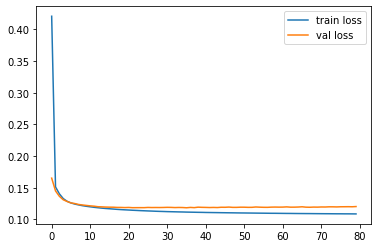

Epoch: 1
Train loss: 0.02818
Val loss: 0.01780
Epoch: 2
Train loss: 0.01716
Val loss: 0.01685
Epoch: 3
Train loss: 0.01634
Val loss: 0.01592
Epoch: 4
Train loss: 0.01569
Val loss: 0.01549
Epoch: 5
Train loss: 0.01532
Val loss: 0.01519
Epoch: 6
Train loss: 0.01506
Val loss: 0.01496
Epoch: 7
Train loss: 0.01484
Val loss: 0.01473
Epoch: 8
Train loss: 0.01466
Val loss: 0.01451
Epoch: 9
Train loss: 0.01453
Val loss: 0.01447
Epoch: 10
Train loss: 0.01440
Val loss: 0.01435
Epoch: 11
Train loss: 0.01427
Val loss: 0.01421
Epoch: 12
Train loss: 0.01417
Val loss: 0.01404


In [ ]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [10,20,50,80,100,120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

Epoch: 1
Train loss: 0.41868
Val loss: 0.16491
Epoch: 2
Train loss: 0.15141
Val loss: 0.14430
Epoch: 3
Train loss: 0.13888
Val loss: 0.13431
Epoch: 4
Train loss: 0.13127
Val loss: 0.12983
Epoch: 5
Train loss: 0.12741
Val loss: 0.12742
Epoch: 6
Train loss: 0.12511
Val loss: 0.12616
Epoch: 7
Train loss: 0.12344
Val loss: 0.12481
Epoch: 8
Train loss: 0.12206
Val loss: 0.12374
Epoch: 9
Train loss: 0.12097
Val loss: 0.12285
Epoch: 10
Train loss: 0.11999
Val loss: 0.12216
Epoch: 11
Train loss: 0.11922
Val loss: 0.12217
Epoch: 12
Train loss: 0.11853
Val loss: 0.12144
Epoch: 13
Train loss: 0.11793
Val loss: 0.12060
Epoch: 14
Train loss: 0.11740
Val loss: 0.12065
Epoch: 15
Train loss: 0.11695
Val loss: 0.11969
Epoch: 16
Train loss: 0.11648
Val loss: 0.11981
Epoch: 17
Train loss: 0.11611
Val loss: 0.11933
Epoch: 18
Train loss: 0.11573
Val loss: 0.11930
Epoch: 19
Train loss: 0.11534
Val loss: 0.11951
Epoch: 20
Train loss: 0.11504
Val loss: 0.11918
Epoch: 21
Train loss: 0.11474
Val loss: 0.11925
E

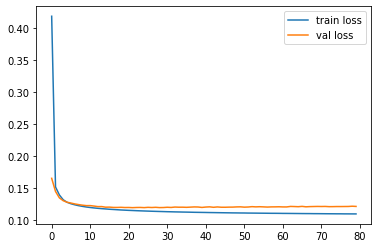

Epoch: 1
Train loss: 0.02821
Val loss: 0.01775
Epoch: 2
Train loss: 0.01716
Val loss: 0.01679
Epoch: 3
Train loss: 0.01635
Val loss: 0.01598
Epoch: 4
Train loss: 0.01568
Val loss: 0.01548
Epoch: 5
Train loss: 0.01526
Val loss: 0.01510
Epoch: 6
Train loss: 0.01494
Val loss: 0.01471
Epoch: 7
Train loss: 0.01463
Val loss: 0.01449
Epoch: 8
Train loss: 0.01435
Val loss: 0.01417
Epoch: 9
Train loss: 0.01409
Val loss: 0.01394
Epoch: 10
Train loss: 0.01387
Val loss: 0.01376
Epoch: 11
Train loss: 0.01372
Val loss: 0.01367
Epoch: 12
Train loss: 0.01358
Val loss: 0.01353
Epoch: 13
Train loss: 0.01351
Val loss: 0.01354
Epoch: 14
Train loss: 0.01347
Val loss: 0.01350
Epoch: 15
Train loss: 0.01343
Val loss: 0.01344
Epoch: 16
Train loss: 0.01340
Val loss: 0.01346
Epoch: 17
Train loss: 0.01337
Val loss: 0.01348
Epoch: 18
Train loss: 0.01334
Val loss: 0.01351
Epoch: 19
Train loss: 0.01331
Val loss: 0.01347
Epoch: 20
Train loss: 0.01329
Val loss: 0.01342
Epoch: 21
Train loss: 0.01328
Val loss: 0.01340
E

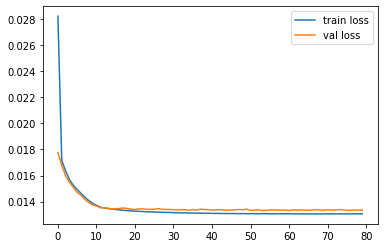

Epoch: 1
Train loss: 0.02821
Val loss: 0.01781
Epoch: 2
Train loss: 0.01723
Val loss: 0.01715
Epoch: 3
Train loss: 0.01643
Val loss: 0.01606
Epoch: 4
Train loss: 0.01576
Val loss: 0.01557
Epoch: 5
Train loss: 0.01538
Val loss: 0.01533
Epoch: 6
Train loss: 0.01514
Val loss: 0.01505
Epoch: 7
Train loss: 0.01493
Val loss: 0.01484
Epoch: 8
Train loss: 0.01475
Val loss: 0.01465
Epoch: 9
Train loss: 0.01459
Val loss: 0.01452
Epoch: 10
Train loss: 0.01444
Val loss: 0.01436
Epoch: 11
Train loss: 0.01430
Val loss: 0.01428
Epoch: 12
Train loss: 0.01419
Val loss: 0.01411
Epoch: 13
Train loss: 0.01407
Val loss: 0.01405
Epoch: 14
Train loss: 0.01398
Val loss: 0.01394
Epoch: 15
Train loss: 0.01389
Val loss: 0.01386
Epoch: 16
Train loss: 0.01381
Val loss: 0.01381
Epoch: 17
Train loss: 0.01372
Val loss: 0.01375
Epoch: 18
Train loss: 0.01365
Val loss: 0.01361
Epoch: 19
Train loss: 0.01357
Val loss: 0.01360
Epoch: 20
Train loss: 0.01352
Val loss: 0.01352
Epoch: 21
Train loss: 0.01346
Val loss: 0.01352
E

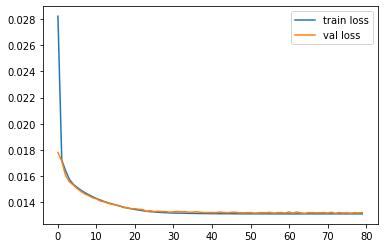

Epoch: 1
Train loss: 0.57918
Val loss: 0.21854
Epoch: 2
Train loss: 0.15585
Val loss: 0.14813
Epoch: 3
Train loss: 0.14368
Val loss: 0.14126
Epoch: 4
Train loss: 0.13632
Val loss: 0.13478
Epoch: 5
Train loss: 0.13071
Val loss: 0.13078
Epoch: 6
Train loss: 0.12782
Val loss: 0.12908
Epoch: 7
Train loss: 0.12623
Val loss: 0.12732
Epoch: 8
Train loss: 0.12525
Val loss: 0.12776
Epoch: 9
Train loss: 0.12452
Val loss: 0.12624
Epoch: 10
Train loss: 0.12394
Val loss: 0.12595
Epoch: 11
Train loss: 0.12336
Val loss: 0.12530
Epoch: 12
Train loss: 0.12285
Val loss: 0.12440
Epoch: 13
Train loss: 0.12235
Val loss: 0.12371
Epoch: 14
Train loss: 0.12191
Val loss: 0.12315
Epoch: 15
Train loss: 0.12155
Val loss: 0.12298
Epoch: 16
Train loss: 0.12118
Val loss: 0.12224
Epoch: 17
Train loss: 0.12088
Val loss: 0.12209
Epoch: 18
Train loss: 0.12053
Val loss: 0.12212
Epoch: 19
Train loss: 0.12022
Val loss: 0.12164
Epoch: 20
Train loss: 0.11993
Val loss: 0.12173
Epoch: 21
Train loss: 0.11969
Val loss: 0.12114
E

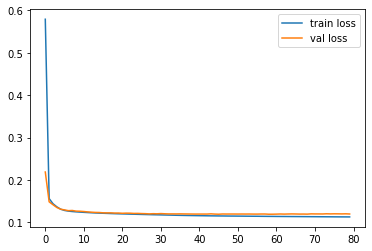

Epoch: 1
Train loss: 0.03063
Val loss: 0.01856
Epoch: 2
Train loss: 0.01805
Val loss: 0.01765
Epoch: 3
Train loss: 0.01731
Val loss: 0.01720
Epoch: 4
Train loss: 0.01668
Val loss: 0.01645
Epoch: 5
Train loss: 0.01628
Val loss: 0.01630
Epoch: 6
Train loss: 0.01605
Val loss: 0.01607
Epoch: 7
Train loss: 0.01590
Val loss: 0.01587
Epoch: 8
Train loss: 0.01578
Val loss: 0.01580
Epoch: 9
Train loss: 0.01567
Val loss: 0.01576
Epoch: 10
Train loss: 0.01558
Val loss: 0.01549
Epoch: 11
Train loss: 0.01551
Val loss: 0.01560
Epoch: 12
Train loss: 0.01545
Val loss: 0.01540
Epoch: 13
Train loss: 0.01539
Val loss: 0.01546
Epoch: 14
Train loss: 0.01535
Val loss: 0.01540
Epoch: 15
Train loss: 0.01531
Val loss: 0.01525
Epoch: 16
Train loss: 0.01526
Val loss: 0.01522
Epoch: 17
Train loss: 0.01522
Val loss: 0.01522
Epoch: 18
Train loss: 0.01516
Val loss: 0.01522
Epoch: 19
Train loss: 0.01511
Val loss: 0.01513
Epoch: 20
Train loss: 0.01504
Val loss: 0.01507
Epoch: 21
Train loss: 0.01499
Val loss: 0.01502
E

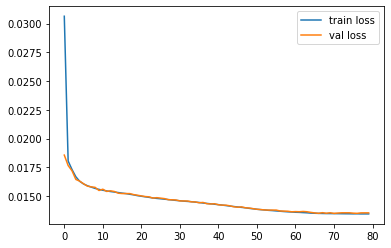

Epoch: 1
Train loss: 0.03052
Val loss: 0.01912
Epoch: 2
Train loss: 0.01799
Val loss: 0.01788
Epoch: 3
Train loss: 0.01726
Val loss: 0.01719
Epoch: 4
Train loss: 0.01663
Val loss: 0.01666
Epoch: 5
Train loss: 0.01625
Val loss: 0.01614
Epoch: 6
Train loss: 0.01601
Val loss: 0.01605
Epoch: 7
Train loss: 0.01584
Val loss: 0.01584
Epoch: 8
Train loss: 0.01570
Val loss: 0.01580
Epoch: 9
Train loss: 0.01558
Val loss: 0.01576
Epoch: 10
Train loss: 0.01546
Val loss: 0.01546
Epoch: 11
Train loss: 0.01536
Val loss: 0.01542
Epoch: 12
Train loss: 0.01526
Val loss: 0.01532
Epoch: 13
Train loss: 0.01518
Val loss: 0.01524
Epoch: 14
Train loss: 0.01511
Val loss: 0.01521
Epoch: 15
Train loss: 0.01505
Val loss: 0.01513
Epoch: 16
Train loss: 0.01499
Val loss: 0.01508
Epoch: 17
Train loss: 0.01493
Val loss: 0.01504
Epoch: 18
Train loss: 0.01489
Val loss: 0.01495
Epoch: 19
Train loss: 0.01483
Val loss: 0.01490
Epoch: 20
Train loss: 0.01479
Val loss: 0.01492
Epoch: 21
Train loss: 0.01475
Val loss: 0.01478
E

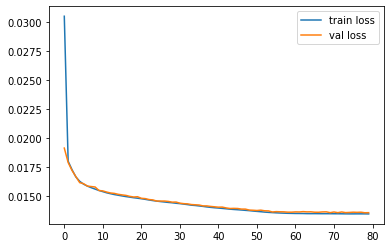

Epoch: 1
Train loss: 0.67697
Val loss: 0.61646
Epoch: 2
Train loss: 0.31456
Val loss: 0.15623
Epoch: 3
Train loss: 0.14949
Val loss: 0.15145
Epoch: 4
Train loss: 0.14632
Val loss: 0.14712
Epoch: 5
Train loss: 0.14097
Val loss: 0.14194
Epoch: 6
Train loss: 0.13641
Val loss: 0.13865
Epoch: 7
Train loss: 0.13286
Val loss: 0.13435
Epoch: 8
Train loss: 0.13042
Val loss: 0.13419
Epoch: 9
Train loss: 0.12892
Val loss: 0.13254
Epoch: 10
Train loss: 0.12787
Val loss: 0.13119
Epoch: 11
Train loss: 0.12717
Val loss: 0.13067
Epoch: 12
Train loss: 0.12656
Val loss: 0.13022
Epoch: 13
Train loss: 0.12602
Val loss: 0.12967
Epoch: 14
Train loss: 0.12548
Val loss: 0.12829
Epoch: 15
Train loss: 0.12503
Val loss: 0.12815
Epoch: 16
Train loss: 0.12461
Val loss: 0.12742
Epoch: 17
Train loss: 0.12426
Val loss: 0.12725
Epoch: 18
Train loss: 0.12389
Val loss: 0.12705
Epoch: 19
Train loss: 0.12361
Val loss: 0.12684
Epoch: 20
Train loss: 0.12333
Val loss: 0.12662
Epoch: 21
Train loss: 0.12308
Val loss: 0.12585
E

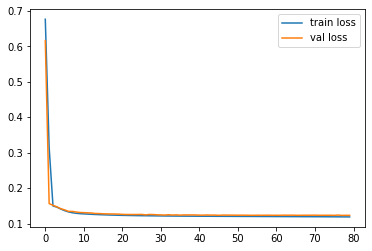

Epoch: 1
Train loss: 0.03296
Val loss: 0.02000
Epoch: 2
Train loss: 0.01896
Val loss: 0.01903
Epoch: 3
Train loss: 0.01805
Val loss: 0.01802
Epoch: 4
Train loss: 0.01733
Val loss: 0.01744
Epoch: 5
Train loss: 0.01688
Val loss: 0.01703
Epoch: 6
Train loss: 0.01662
Val loss: 0.01690
Epoch: 7
Train loss: 0.01643
Val loss: 0.01679
Epoch: 8
Train loss: 0.01629
Val loss: 0.01669
Epoch: 9
Train loss: 0.01618
Val loss: 0.01641
Epoch: 10
Train loss: 0.01610
Val loss: 0.01648
Epoch: 11
Train loss: 0.01604
Val loss: 0.01629
Epoch: 12
Train loss: 0.01599
Val loss: 0.01630
Epoch: 13
Train loss: 0.01593
Val loss: 0.01624
Epoch: 14
Train loss: 0.01588
Val loss: 0.01627
Epoch: 15
Train loss: 0.01584
Val loss: 0.01625
Epoch: 16
Train loss: 0.01580
Val loss: 0.01602
Epoch: 17
Train loss: 0.01578
Val loss: 0.01604
Epoch: 18
Train loss: 0.01575
Val loss: 0.01615
Epoch: 19
Train loss: 0.01573
Val loss: 0.01609
Epoch: 20
Train loss: 0.01570
Val loss: 0.01591
Epoch: 21
Train loss: 0.01569
Val loss: 0.01601
E

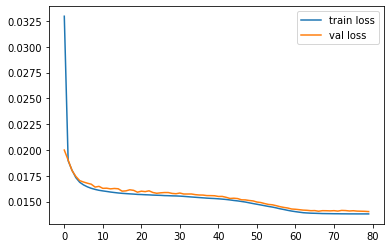

Epoch: 1
Train loss: 0.03302
Val loss: 0.01977
Epoch: 2
Train loss: 0.01897
Val loss: 0.01867
Epoch: 3
Train loss: 0.01805
Val loss: 0.01779
Epoch: 4
Train loss: 0.01736
Val loss: 0.01737
Epoch: 5
Train loss: 0.01691
Val loss: 0.01688
Epoch: 6
Train loss: 0.01664
Val loss: 0.01674
Epoch: 7
Train loss: 0.01644
Val loss: 0.01679
Epoch: 8
Train loss: 0.01631
Val loss: 0.01643
Epoch: 9
Train loss: 0.01619
Val loss: 0.01629
Epoch: 10
Train loss: 0.01610
Val loss: 0.01637
Epoch: 11
Train loss: 0.01603
Val loss: 0.01615
Epoch: 12
Train loss: 0.01595
Val loss: 0.01628
Epoch: 13
Train loss: 0.01590
Val loss: 0.01603
Epoch: 14
Train loss: 0.01585
Val loss: 0.01603
Epoch: 15
Train loss: 0.01581
Val loss: 0.01609
Epoch: 16
Train loss: 0.01578
Val loss: 0.01589
Epoch: 17
Train loss: 0.01575
Val loss: 0.01609
Epoch: 18
Train loss: 0.01573
Val loss: 0.01588
Epoch: 19
Train loss: 0.01570
Val loss: 0.01586
Epoch: 20
Train loss: 0.01568
Val loss: 0.01601
Epoch: 21
Train loss: 0.01566
Val loss: 0.01588
E

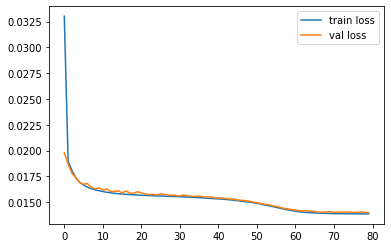

Epoch: 1
Train loss: 0.69399
Val loss: 0.64883
Epoch: 2
Train loss: 0.51762
Val loss: 0.25865
Epoch: 3
Train loss: 0.16603
Val loss: 0.15768
Epoch: 4
Train loss: 0.15155
Val loss: 0.15305
Epoch: 5
Train loss: 0.14775
Val loss: 0.14798
Epoch: 6
Train loss: 0.14331
Val loss: 0.14553
Epoch: 7
Train loss: 0.13954
Val loss: 0.14296
Epoch: 8
Train loss: 0.13671
Val loss: 0.13883
Epoch: 9
Train loss: 0.13446
Val loss: 0.13588
Epoch: 10
Train loss: 0.13257
Val loss: 0.13525
Epoch: 11
Train loss: 0.13120
Val loss: 0.13294
Epoch: 12
Train loss: 0.13008
Val loss: 0.13306
Epoch: 13
Train loss: 0.12917
Val loss: 0.13146
Epoch: 14
Train loss: 0.12839
Val loss: 0.13166
Epoch: 15
Train loss: 0.12769
Val loss: 0.13054
Epoch: 16
Train loss: 0.12703
Val loss: 0.13023
Epoch: 17
Train loss: 0.12643
Val loss: 0.12845
Epoch: 18
Train loss: 0.12592
Val loss: 0.12910
Epoch: 19
Train loss: 0.12550
Val loss: 0.12815
Epoch: 20
Train loss: 0.12512
Val loss: 0.12773
Epoch: 21
Train loss: 0.12480
Val loss: 0.12762
E

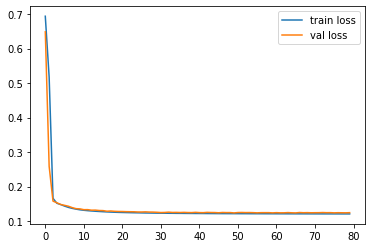

Epoch: 1
Train loss: 0.03461
Val loss: 0.02065
Epoch: 2
Train loss: 0.01955
Val loss: 0.01922
Epoch: 3
Train loss: 0.01857
Val loss: 0.01850
Epoch: 4
Train loss: 0.01783
Val loss: 0.01769
Epoch: 5
Train loss: 0.01731
Val loss: 0.01722
Epoch: 6
Train loss: 0.01698
Val loss: 0.01712
Epoch: 7
Train loss: 0.01678
Val loss: 0.01664
Epoch: 8
Train loss: 0.01660
Val loss: 0.01664
Epoch: 9
Train loss: 0.01648
Val loss: 0.01682
Epoch: 10
Train loss: 0.01637
Val loss: 0.01660
Epoch: 11
Train loss: 0.01629
Val loss: 0.01635
Epoch: 12
Train loss: 0.01621
Val loss: 0.01637
Epoch: 13
Train loss: 0.01615
Val loss: 0.01636
Epoch: 14
Train loss: 0.01611
Val loss: 0.01614
Epoch: 15
Train loss: 0.01606
Val loss: 0.01627
Epoch: 16
Train loss: 0.01604
Val loss: 0.01631
Epoch: 17
Train loss: 0.01601
Val loss: 0.01607
Epoch: 18
Train loss: 0.01599
Val loss: 0.01619
Epoch: 19
Train loss: 0.01597
Val loss: 0.01628
Epoch: 20
Train loss: 0.01596
Val loss: 0.01621
Epoch: 21
Train loss: 0.01594
Val loss: 0.01625
E

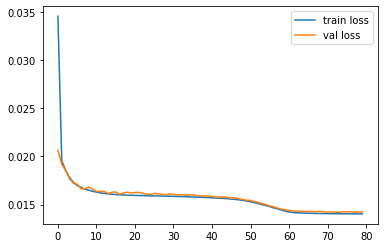

Epoch: 1
Train loss: 0.03455
Val loss: 0.02085
Epoch: 2
Train loss: 0.01956
Val loss: 0.01882
Epoch: 3
Train loss: 0.01856
Val loss: 0.01836
Epoch: 4
Train loss: 0.01781
Val loss: 0.01772
Epoch: 5
Train loss: 0.01733
Val loss: 0.01753
Epoch: 6
Train loss: 0.01701
Val loss: 0.01725
Epoch: 7
Train loss: 0.01679
Val loss: 0.01673
Epoch: 8
Train loss: 0.01661
Val loss: 0.01667
Epoch: 9
Train loss: 0.01646
Val loss: 0.01678
Epoch: 10
Train loss: 0.01638
Val loss: 0.01683
Epoch: 11
Train loss: 0.01629
Val loss: 0.01638
Epoch: 12
Train loss: 0.01623
Val loss: 0.01621
Epoch: 13
Train loss: 0.01617
Val loss: 0.01612
Epoch: 14
Train loss: 0.01613
Val loss: 0.01618
Epoch: 15
Train loss: 0.01609
Val loss: 0.01633
Epoch: 16
Train loss: 0.01607
Val loss: 0.01637
Epoch: 17
Train loss: 0.01604
Val loss: 0.01625
Epoch: 18
Train loss: 0.01602
Val loss: 0.01609
Epoch: 19
Train loss: 0.01600
Val loss: 0.01623
Epoch: 20
Train loss: 0.01598
Val loss: 0.01601
Epoch: 21
Train loss: 0.01597
Val loss: 0.01604
E

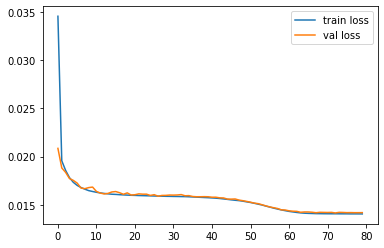

In [9]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

In [14]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [10,12,14,16,18,20,50,80,100,120,150,180,200]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean_es = MLP_light(p, p).to(device)
    if p<=150:
        md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'_es.pt'))
    else:
        md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'.pt'))
    
    md_q025_es = MLP_light(p, p).to(device)
    if p<=150:
        md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'_es.pt'))
    else:
        md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'.pt'))

    md_q975_es = MLP_light(p, p).to(device)
    if p<=150:
        md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'_es.pt'))
    else:
        md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'.pt'))

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

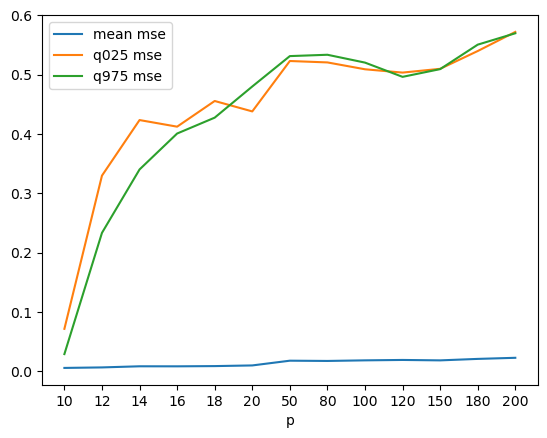

In [16]:
plt.plot(all_mean_mse)
plt.plot(all_q025_mse)
plt.plot(all_q975_mse)
plt.legend(['mean mse', 'q025 mse', 'q975 mse'])
plt.xticks(range(13), ['10', '12', '14', '16', '18', '20', '50', '80', '100', '120', '150', '180', '200'])
plt.xlabel('p')
plt.show()

Epoch: 1
Train loss: 0.13199
Val loss: 0.11156
Epoch: 2
Train loss: 0.11186
Val loss: 0.10740
Epoch: 3
Train loss: 0.11007
Val loss: 0.10818
Epoch: 4
Train loss: 0.10906
Val loss: 0.10659
Epoch: 5
Train loss: 0.10836
Val loss: 0.10823
Epoch: 6
Train loss: 0.10782
Val loss: 0.10609
Epoch: 7
Train loss: 0.10746
Val loss: 0.10668
Epoch: 8
Train loss: 0.10699
Val loss: 0.10707
Epoch: 9
Train loss: 0.10669
Val loss: 0.10579
Epoch: 10
Train loss: 0.10637
Val loss: 0.10554
Epoch: 11
Train loss: 0.10621
Val loss: 0.10507
Epoch: 12
Train loss: 0.10594
Val loss: 0.10541
Epoch: 13
Train loss: 0.10579
Val loss: 0.10487
Epoch: 14
Train loss: 0.10557
Val loss: 0.10592
Epoch: 15
Train loss: 0.10541
Val loss: 0.10492
Epoch: 16
Train loss: 0.10530
Val loss: 0.10494
Epoch: 17
Train loss: 0.10507
Val loss: 0.10476
Epoch: 18
Train loss: 0.10502
Val loss: 0.10436
Epoch: 19
Train loss: 0.10488
Val loss: 0.10419
Epoch: 20
Train loss: 0.10471
Val loss: 0.10449
Epoch: 21
Train loss: 0.10460
Val loss: 0.10499
E

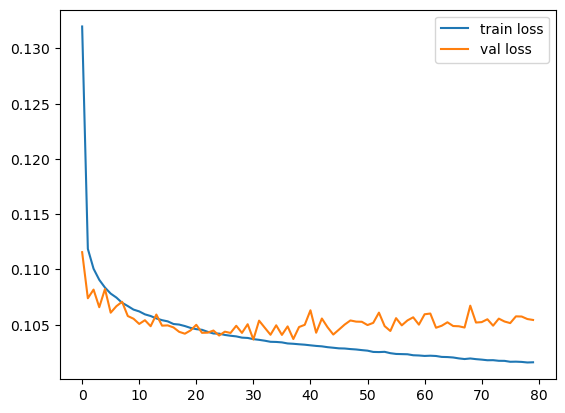

Epoch: 1
Train loss: 0.01502
Val loss: 0.01249
Epoch: 2
Train loss: 0.01273
Val loss: 0.01231
Epoch: 3
Train loss: 0.01241
Val loss: 0.01215
Epoch: 4
Train loss: 0.01225
Val loss: 0.01216
Epoch: 5
Train loss: 0.01215
Val loss: 0.01193
Epoch: 6
Train loss: 0.01208
Val loss: 0.01192
Epoch: 7
Train loss: 0.01201
Val loss: 0.01192
Epoch: 8
Train loss: 0.01197
Val loss: 0.01181
Epoch: 9
Train loss: 0.01194
Val loss: 0.01182
Epoch: 10
Train loss: 0.01191
Val loss: 0.01175
Epoch: 11
Train loss: 0.01189
Val loss: 0.01185
Epoch: 12
Train loss: 0.01185
Val loss: 0.01181
Epoch: 13
Train loss: 0.01184
Val loss: 0.01163
Epoch: 14
Train loss: 0.01182
Val loss: 0.01175
Epoch: 15
Train loss: 0.01180
Val loss: 0.01175
Epoch: 16
Train loss: 0.01179
Val loss: 0.01172
Epoch: 17
Train loss: 0.01176
Val loss: 0.01182
Epoch: 18
Train loss: 0.01176
Val loss: 0.01177
Save early stopping model at epoch 18
Epoch: 19
Train loss: 0.01175
Val loss: 0.01171
Epoch: 20
Train loss: 0.01174
Val loss: 0.01171
Epoch: 21
T

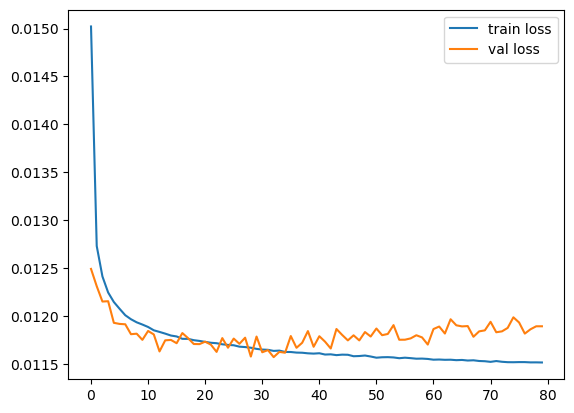

Epoch: 1
Train loss: 0.01500
Val loss: 0.01244
Epoch: 2
Train loss: 0.01250
Val loss: 0.01235
Epoch: 3
Train loss: 0.01220
Val loss: 0.01190
Epoch: 4
Train loss: 0.01205
Val loss: 0.01192
Epoch: 5
Train loss: 0.01194
Val loss: 0.01175
Epoch: 6
Train loss: 0.01187
Val loss: 0.01178
Epoch: 7
Train loss: 0.01181
Val loss: 0.01170
Epoch: 8
Train loss: 0.01176
Val loss: 0.01165
Epoch: 9
Train loss: 0.01172
Val loss: 0.01143
Epoch: 10
Train loss: 0.01168
Val loss: 0.01156
Epoch: 11
Train loss: 0.01165
Val loss: 0.01148
Epoch: 12
Train loss: 0.01162
Val loss: 0.01151
Epoch: 13
Train loss: 0.01159
Val loss: 0.01138
Epoch: 14
Train loss: 0.01157
Val loss: 0.01147
Epoch: 15
Train loss: 0.01155
Val loss: 0.01136
Epoch: 16
Train loss: 0.01153
Val loss: 0.01147
Epoch: 17
Train loss: 0.01151
Val loss: 0.01141
Epoch: 18
Train loss: 0.01151
Val loss: 0.01150
Epoch: 19
Train loss: 0.01149
Val loss: 0.01128
Epoch: 20
Train loss: 0.01147
Val loss: 0.01135
Epoch: 21
Train loss: 0.01147
Val loss: 0.01134
E

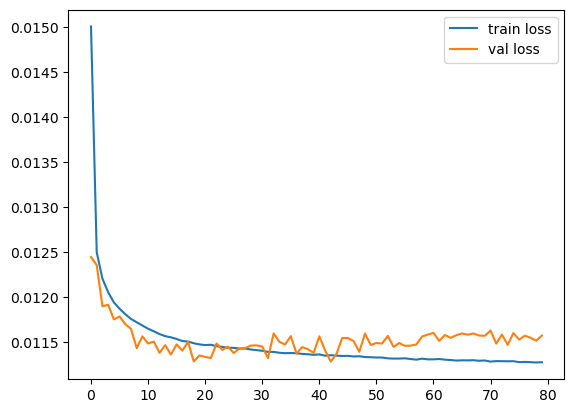

Epoch: 1
Train loss: 0.13456
Val loss: 0.11751
Epoch: 2
Train loss: 0.11281
Val loss: 0.11440
Epoch: 3
Train loss: 0.11060
Val loss: 0.11556
Epoch: 4
Train loss: 0.10953
Val loss: 0.11367
Epoch: 5
Train loss: 0.10880
Val loss: 0.11334
Epoch: 6
Train loss: 0.10828
Val loss: 0.11296
Epoch: 7
Train loss: 0.10781
Val loss: 0.11298
Epoch: 8
Train loss: 0.10749
Val loss: 0.11096
Epoch: 9
Train loss: 0.10720
Val loss: 0.11175
Epoch: 10
Train loss: 0.10690
Val loss: 0.11115
Epoch: 11
Train loss: 0.10668
Val loss: 0.11369
Epoch: 12
Train loss: 0.10652
Val loss: 0.11183
Epoch: 13
Train loss: 0.10627
Val loss: 0.11315
Save early stopping model at epoch 13
Epoch: 14
Train loss: 0.10612
Val loss: 0.11171
Epoch: 15
Train loss: 0.10597
Val loss: 0.11271
Epoch: 16
Train loss: 0.10577
Val loss: 0.11218
Epoch: 17
Train loss: 0.10565
Val loss: 0.11115
Epoch: 18
Train loss: 0.10547
Val loss: 0.11171
Epoch: 19
Train loss: 0.10533
Val loss: 0.11196
Epoch: 20
Train loss: 0.10513
Val loss: 0.11120
Epoch: 21
T

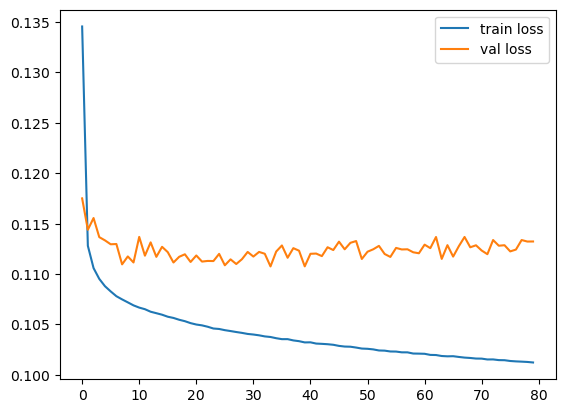

Epoch: 1
Train loss: 0.01531
Val loss: 0.01357
Epoch: 2
Train loss: 0.01313
Val loss: 0.01307
Epoch: 3
Train loss: 0.01281
Val loss: 0.01285
Epoch: 4
Train loss: 0.01264
Val loss: 0.01278
Epoch: 5
Train loss: 0.01254
Val loss: 0.01272
Epoch: 6
Train loss: 0.01246
Val loss: 0.01259
Epoch: 7
Train loss: 0.01242
Val loss: 0.01263
Epoch: 8
Train loss: 0.01237
Val loss: 0.01256
Epoch: 9
Train loss: 0.01234
Val loss: 0.01260
Epoch: 10
Train loss: 0.01229
Val loss: 0.01243
Epoch: 11
Train loss: 0.01227
Val loss: 0.01244
Epoch: 12
Train loss: 0.01223
Val loss: 0.01254
Epoch: 13
Train loss: 0.01220
Val loss: 0.01250
Epoch: 14
Train loss: 0.01218
Val loss: 0.01237
Epoch: 15
Train loss: 0.01216
Val loss: 0.01246
Epoch: 16
Train loss: 0.01214
Val loss: 0.01247
Epoch: 17
Train loss: 0.01212
Val loss: 0.01251
Epoch: 18
Train loss: 0.01210
Val loss: 0.01236
Epoch: 19
Train loss: 0.01208
Val loss: 0.01224
Epoch: 20
Train loss: 0.01206
Val loss: 0.01248
Epoch: 21
Train loss: 0.01206
Val loss: 0.01232
E

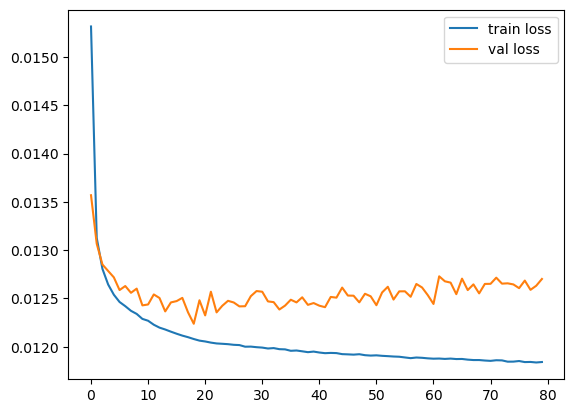

Epoch: 1
Train loss: 0.01536
Val loss: 0.01368
Epoch: 2
Train loss: 0.01292
Val loss: 0.01280
Epoch: 3
Train loss: 0.01260
Val loss: 0.01262
Epoch: 4
Train loss: 0.01242
Val loss: 0.01236
Epoch: 5
Train loss: 0.01231
Val loss: 0.01254
Epoch: 6
Train loss: 0.01223
Val loss: 0.01248
Epoch: 7
Train loss: 0.01217
Val loss: 0.01235
Epoch: 8
Train loss: 0.01211
Val loss: 0.01232
Epoch: 9
Train loss: 0.01207
Val loss: 0.01230
Epoch: 10
Train loss: 0.01203
Val loss: 0.01224
Epoch: 11
Train loss: 0.01200
Val loss: 0.01224
Epoch: 12
Train loss: 0.01197
Val loss: 0.01224
Epoch: 13
Train loss: 0.01195
Val loss: 0.01222
Epoch: 14
Train loss: 0.01191
Val loss: 0.01229
Epoch: 15
Train loss: 0.01190
Val loss: 0.01223
Epoch: 16
Train loss: 0.01188
Val loss: 0.01222
Epoch: 17
Train loss: 0.01186
Val loss: 0.01211
Epoch: 18
Train loss: 0.01184
Val loss: 0.01219
Epoch: 19
Train loss: 0.01183
Val loss: 0.01212
Epoch: 20
Train loss: 0.01181
Val loss: 0.01213
Epoch: 21
Train loss: 0.01181
Val loss: 0.01216
E

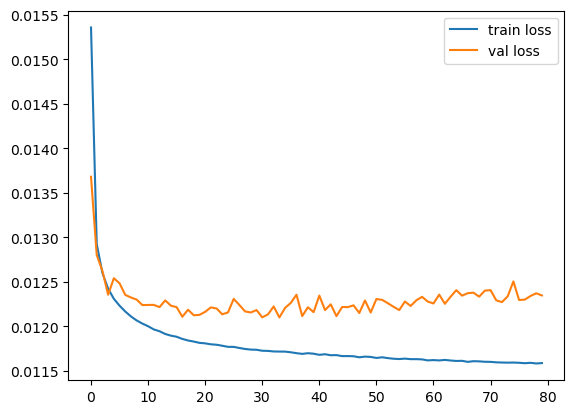

Epoch: 1
Train loss: 0.13691
Val loss: 0.11463
Epoch: 2
Train loss: 0.11289
Val loss: 0.10881
Epoch: 3
Train loss: 0.11077
Val loss: 0.10834
Epoch: 4
Train loss: 0.10969
Val loss: 0.10956
Epoch: 5
Train loss: 0.10892
Val loss: 0.10934
Epoch: 6
Train loss: 0.10837
Val loss: 0.10784
Epoch: 7
Train loss: 0.10799
Val loss: 0.10692
Epoch: 8
Train loss: 0.10765
Val loss: 0.10752
Epoch: 9
Train loss: 0.10721
Val loss: 0.10754
Epoch: 10
Train loss: 0.10698
Val loss: 0.10695
Epoch: 11
Train loss: 0.10674
Val loss: 0.10784
Epoch: 12
Train loss: 0.10659
Val loss: 0.10709
Save early stopping model at epoch 12
Epoch: 13
Train loss: 0.10634
Val loss: 0.10769
Epoch: 14
Train loss: 0.10614
Val loss: 0.10823
Epoch: 15
Train loss: 0.10598
Val loss: 0.10734
Epoch: 16
Train loss: 0.10580
Val loss: 0.10763
Epoch: 17
Train loss: 0.10566
Val loss: 0.10760
Epoch: 18
Train loss: 0.10550
Val loss: 0.10734
Epoch: 19
Train loss: 0.10539
Val loss: 0.10715
Epoch: 20
Train loss: 0.10521
Val loss: 0.10737
Epoch: 21
T

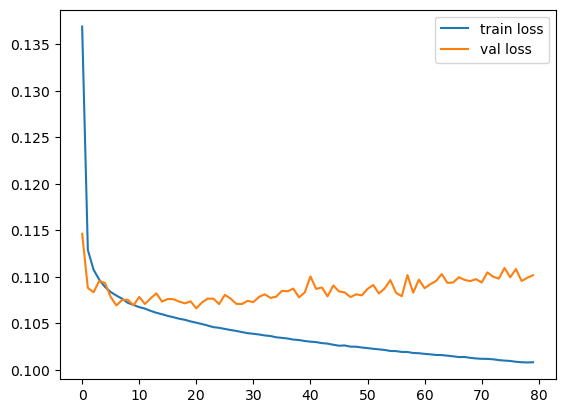

Epoch: 1
Train loss: 0.01566
Val loss: 0.01355
Epoch: 2
Train loss: 0.01321
Val loss: 0.01304
Epoch: 3
Train loss: 0.01286
Val loss: 0.01295
Epoch: 4
Train loss: 0.01270
Val loss: 0.01267
Epoch: 5
Train loss: 0.01257
Val loss: 0.01268
Epoch: 6
Train loss: 0.01250
Val loss: 0.01270
Epoch: 7
Train loss: 0.01244
Val loss: 0.01255
Epoch: 8
Train loss: 0.01239
Val loss: 0.01267
Epoch: 9
Train loss: 0.01234
Val loss: 0.01252
Epoch: 10
Train loss: 0.01230
Val loss: 0.01251
Epoch: 11
Train loss: 0.01226
Val loss: 0.01255
Epoch: 12
Train loss: 0.01222
Val loss: 0.01242
Epoch: 13
Train loss: 0.01220
Val loss: 0.01237
Epoch: 14
Train loss: 0.01217
Val loss: 0.01246
Epoch: 15
Train loss: 0.01214
Val loss: 0.01237
Epoch: 16
Train loss: 0.01211
Val loss: 0.01228
Epoch: 17
Train loss: 0.01210
Val loss: 0.01242
Epoch: 18
Train loss: 0.01208
Val loss: 0.01237
Epoch: 19
Train loss: 0.01206
Val loss: 0.01241
Epoch: 20
Train loss: 0.01205
Val loss: 0.01250
Epoch: 21
Train loss: 0.01204
Val loss: 0.01231
S

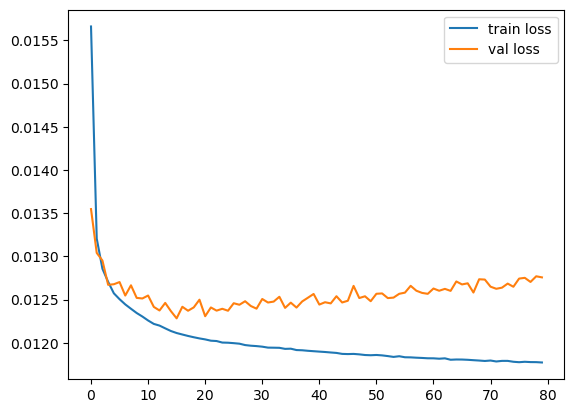

Epoch: 1
Train loss: 0.01561
Val loss: 0.01347
Epoch: 2
Train loss: 0.01309
Val loss: 0.01295
Epoch: 3
Train loss: 0.01275
Val loss: 0.01276
Epoch: 4
Train loss: 0.01261
Val loss: 0.01260
Epoch: 5
Train loss: 0.01250
Val loss: 0.01256
Epoch: 6
Train loss: 0.01242
Val loss: 0.01246
Epoch: 7
Train loss: 0.01237
Val loss: 0.01246
Epoch: 8
Train loss: 0.01231
Val loss: 0.01237
Epoch: 9
Train loss: 0.01228
Val loss: 0.01238
Epoch: 10
Train loss: 0.01223
Val loss: 0.01226
Epoch: 11
Train loss: 0.01220
Val loss: 0.01236
Epoch: 12
Train loss: 0.01217
Val loss: 0.01238
Epoch: 13
Train loss: 0.01214
Val loss: 0.01238
Epoch: 14
Train loss: 0.01211
Val loss: 0.01234
Epoch: 15
Train loss: 0.01208
Val loss: 0.01223
Epoch: 16
Train loss: 0.01206
Val loss: 0.01220
Epoch: 17
Train loss: 0.01203
Val loss: 0.01215
Epoch: 18
Train loss: 0.01201
Val loss: 0.01216
Epoch: 19
Train loss: 0.01199
Val loss: 0.01222
Epoch: 20
Train loss: 0.01197
Val loss: 0.01217
Epoch: 21
Train loss: 0.01197
Val loss: 0.01218
E

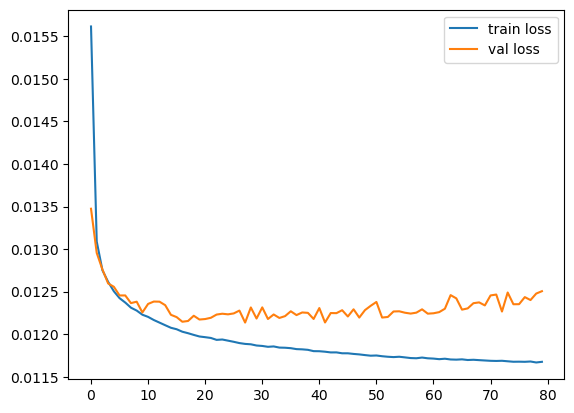

Epoch: 1
Train loss: 0.13872
Val loss: 0.11348
Epoch: 2
Train loss: 0.11350
Val loss: 0.10980
Epoch: 3
Train loss: 0.11125
Val loss: 0.10881
Epoch: 4
Train loss: 0.11009
Val loss: 0.10886
Epoch: 5
Train loss: 0.10937
Val loss: 0.10783
Epoch: 6
Train loss: 0.10884
Val loss: 0.10764
Epoch: 7
Train loss: 0.10838
Val loss: 0.10758
Epoch: 8
Train loss: 0.10807
Val loss: 0.10770
Epoch: 9
Train loss: 0.10777
Val loss: 0.10715
Epoch: 10
Train loss: 0.10754
Val loss: 0.10786
Epoch: 11
Train loss: 0.10726
Val loss: 0.10729
Epoch: 12
Train loss: 0.10701
Val loss: 0.10671
Epoch: 13
Train loss: 0.10685
Val loss: 0.10734
Epoch: 14
Train loss: 0.10664
Val loss: 0.10657
Epoch: 15
Train loss: 0.10639
Val loss: 0.10631
Epoch: 16
Train loss: 0.10625
Val loss: 0.10688
Epoch: 17
Train loss: 0.10603
Val loss: 0.10748
Epoch: 18
Train loss: 0.10590
Val loss: 0.10807
Epoch: 19
Train loss: 0.10570
Val loss: 0.10750
Epoch: 20
Train loss: 0.10558
Val loss: 0.10714
Save early stopping model at epoch 20
Epoch: 21
T

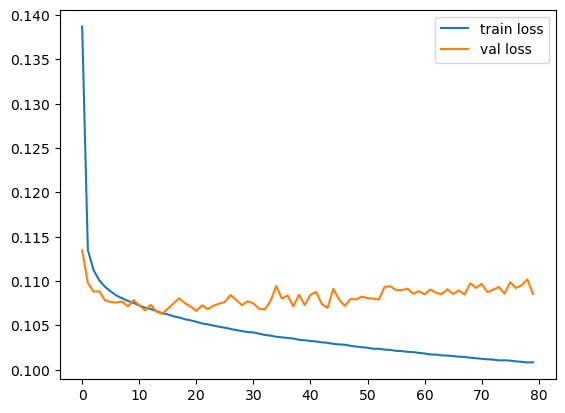

Epoch: 1
Train loss: 0.01596
Val loss: 0.01388
Epoch: 2
Train loss: 0.01350
Val loss: 0.01318
Epoch: 3
Train loss: 0.01311
Val loss: 0.01302
Epoch: 4
Train loss: 0.01293
Val loss: 0.01287
Epoch: 5
Train loss: 0.01282
Val loss: 0.01270
Epoch: 6
Train loss: 0.01274
Val loss: 0.01263
Epoch: 7
Train loss: 0.01268
Val loss: 0.01249
Epoch: 8
Train loss: 0.01263
Val loss: 0.01258
Epoch: 9
Train loss: 0.01258
Val loss: 0.01262
Epoch: 10
Train loss: 0.01253
Val loss: 0.01242
Epoch: 11
Train loss: 0.01250
Val loss: 0.01255
Epoch: 12
Train loss: 0.01246
Val loss: 0.01244
Epoch: 13
Train loss: 0.01243
Val loss: 0.01243
Epoch: 14
Train loss: 0.01240
Val loss: 0.01244
Epoch: 15
Train loss: 0.01237
Val loss: 0.01244
Save early stopping model at epoch 15
Epoch: 16
Train loss: 0.01235
Val loss: 0.01243
Epoch: 17
Train loss: 0.01233
Val loss: 0.01240
Epoch: 18
Train loss: 0.01231
Val loss: 0.01242
Epoch: 19
Train loss: 0.01228
Val loss: 0.01238
Epoch: 20
Train loss: 0.01228
Val loss: 0.01235
Epoch: 21
T

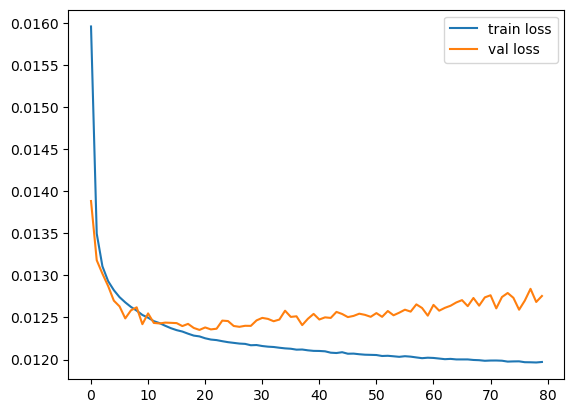

Epoch: 1
Train loss: 0.01597
Val loss: 0.01353
Epoch: 2
Train loss: 0.01333
Val loss: 0.01281
Epoch: 3
Train loss: 0.01297
Val loss: 0.01281
Epoch: 4
Train loss: 0.01281
Val loss: 0.01276
Epoch: 5
Train loss: 0.01270
Val loss: 0.01247
Epoch: 6
Train loss: 0.01262
Val loss: 0.01255
Epoch: 7
Train loss: 0.01254
Val loss: 0.01250
Epoch: 8
Train loss: 0.01248
Val loss: 0.01249
Epoch: 9
Train loss: 0.01243
Val loss: 0.01253
Epoch: 10
Train loss: 0.01240
Val loss: 0.01245
Epoch: 11
Train loss: 0.01235
Val loss: 0.01238
Epoch: 12
Train loss: 0.01231
Val loss: 0.01248
Epoch: 13
Train loss: 0.01228
Val loss: 0.01235
Epoch: 14
Train loss: 0.01225
Val loss: 0.01238
Epoch: 15
Train loss: 0.01223
Val loss: 0.01235
Epoch: 16
Train loss: 0.01220
Val loss: 0.01236
Epoch: 17
Train loss: 0.01219
Val loss: 0.01227
Epoch: 18
Train loss: 0.01218
Val loss: 0.01239
Epoch: 19
Train loss: 0.01215
Val loss: 0.01227
Epoch: 20
Train loss: 0.01214
Val loss: 0.01236
Epoch: 21
Train loss: 0.01212
Val loss: 0.01248
E

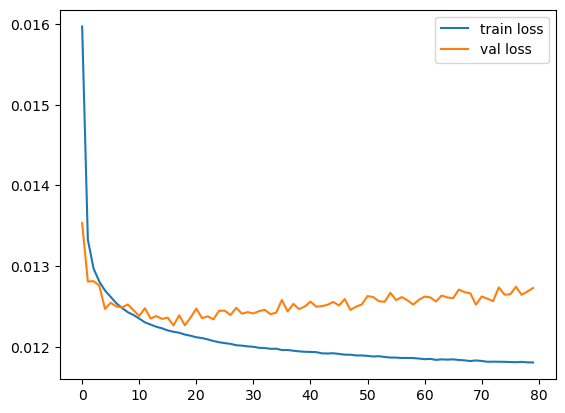

In [12]:
theta = 0.05
a = 10
sigma = 1
lr = 0.001 # learning rate
max_epoch = 80
all_mean_mse = []
all_q025_mse = []
all_q975_mse = []

for p in [12,14,16,18]:
    generator = Generator_eye(p, theta, (-a,a))

    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    gamma_val, beta_val, Y_val = generator.generate_samples(10000)

    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_val = (Y_val - mean) / std 
    train_dataset = TensorDataset(torch.Tensor(Y_train), torch.Tensor(beta_train))
    val_dataset = TensorDataset(torch.Tensor(Y_val), torch.Tensor(beta_val))

    Y_test_normalized = (Y_test - mean) / std 

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

    md_mean = MLP_light(p, p).to(device)
    md_mean_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_mean, md_mean_es, lr, max_epoch, train_dataloader, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_mean.state_dict(), './model/mean_p'+str(p)+'.pt')
    torch.save(md_mean_es.state_dict(), './model/mean_p'+str(p)+'_es.pt')

    md_q025 = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q025, md_q025_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.025, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q025.state_dict(), './model/q025_p'+str(p)+'.pt')
    torch.save(md_q025_es.state_dict(), './model/q025_p'+str(p)+'_es.pt')

    md_q975 = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)
    train_losses, val_losses = train_model(md_q975, md_q975_es, lr, max_epoch, train_dataloader, 
                                            loss_type='quantile', q=0.975, val_data=valid_dataloader)
    show_loss(train_losses, val_losses)
    torch.save(md_q975.state_dict(), './model/q975_p'+str(p)+'.pt')
    torch.save(md_q975_es.state_dict(), './model/q975_p'+str(p)+'_es.pt')

    mse_mean, mse_q025, mse_q975=compute_mses(md_mean_es, md_q025_es, 
                                              md_q975_es, Y_test, Y_test_normalized, theta, a, sigma)
    all_mean_mse.append(mse_mean)
    all_q025_mse.append(mse_q025)
    all_q975_mse.append(mse_q975)

## Evaluation

In [59]:
def show_samples(p):
    generator = Generator_eye(p, theta, (-a,a))
    rng.seed(0)
    gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
    rng.seed(1)
    gamma_test, beta_test, Y_test = generator.generate_samples(10000)

    mean = Y_train.mean(0)
    std = Y_train.std(0)
    Y_train = (Y_train - mean) / std 
    Y_test_normalized = (Y_test - mean) / std 

    md_mean_es = MLP_light(p, p).to(device)
    md_q025_es = MLP_light(p, p).to(device)
    md_q975_es = MLP_light(p, p).to(device)

    md_mean_es.load_state_dict(torch.load('./model/mean_p'+str(p)+'_es.pt'))
    md_q025_es.load_state_dict(torch.load('./model/q025_p'+str(p)+'_es.pt'))
    md_q975_es.load_state_dict(torch.load('./model/q975_p'+str(p)+'_es.pt'))

    pred_mean = predict(md_mean_es, Y_test_normalized)
    pred_q025 = predict(md_q025_es, Y_test_normalized)
    pred_q975 = predict(md_q975_es, Y_test_normalized)

    true_mean = np.zeros_like(Y_test)
    true_q025 = np.zeros_like(Y_test)
    true_q975 = np.zeros_like(Y_test)
    for i in range(Y_test.shape[0]):
        for j in range(Y_test.shape[1]):
            true_mean[i,j] = computePosMean(Y_test[i,j], theta, a, sigma)
            true_q025[i,j], true_q975[i,j] = computePPI(Y_test[i,j], theta, a, sigma)

    subset = np.where(np.abs(beta_test)>2)[0]
    t = 1000 * time.time()
    np.random.seed(int(t) % 2**32)
    rng.shuffle(subset)
    subset = subset[:6]

    plt.figure(figsize=(12,10))
    for i, idx in enumerate(subset):
        plt.subplot(3,2,i+1)
        plt.plot(range(p), true_mean[idx])
        plt.plot(range(p), pred_mean[idx])
        plt.vlines(range(p), true_q025[idx], true_q975[idx], color='red')
        plt.vlines(np.arange(p)+0.1, pred_q025[idx], pred_q975[idx], color='green')
        plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
        plt.ylim(-11,11)
    plt.show()

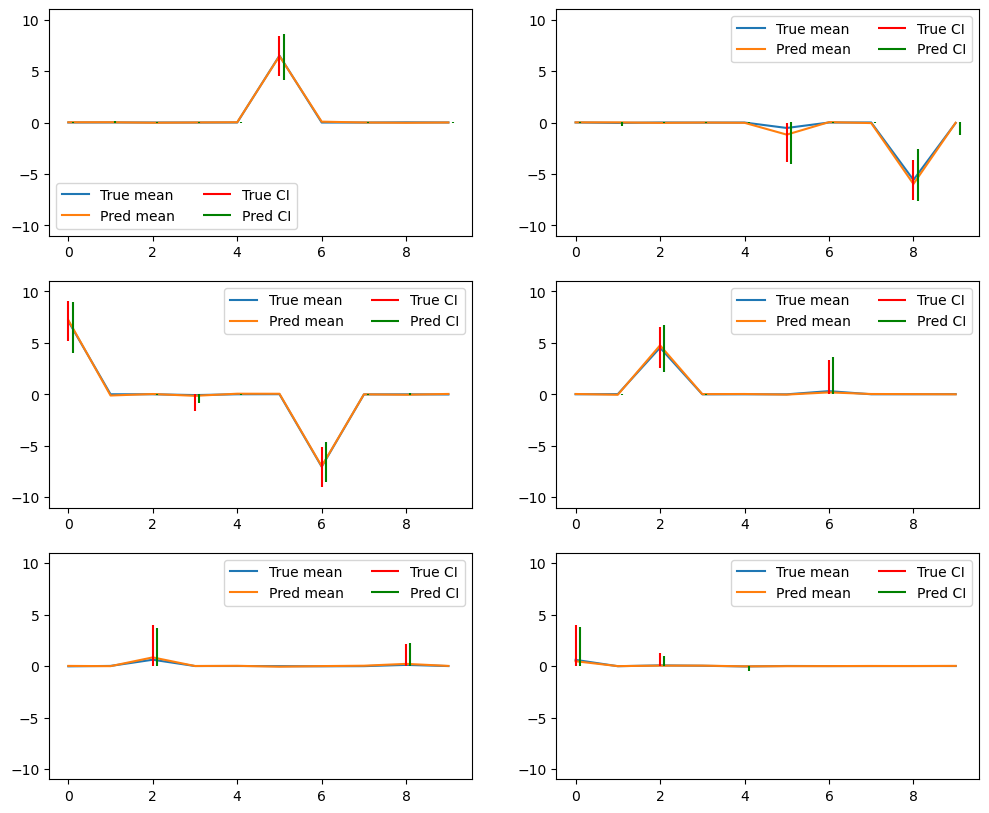

In [60]:
show_samples(10)

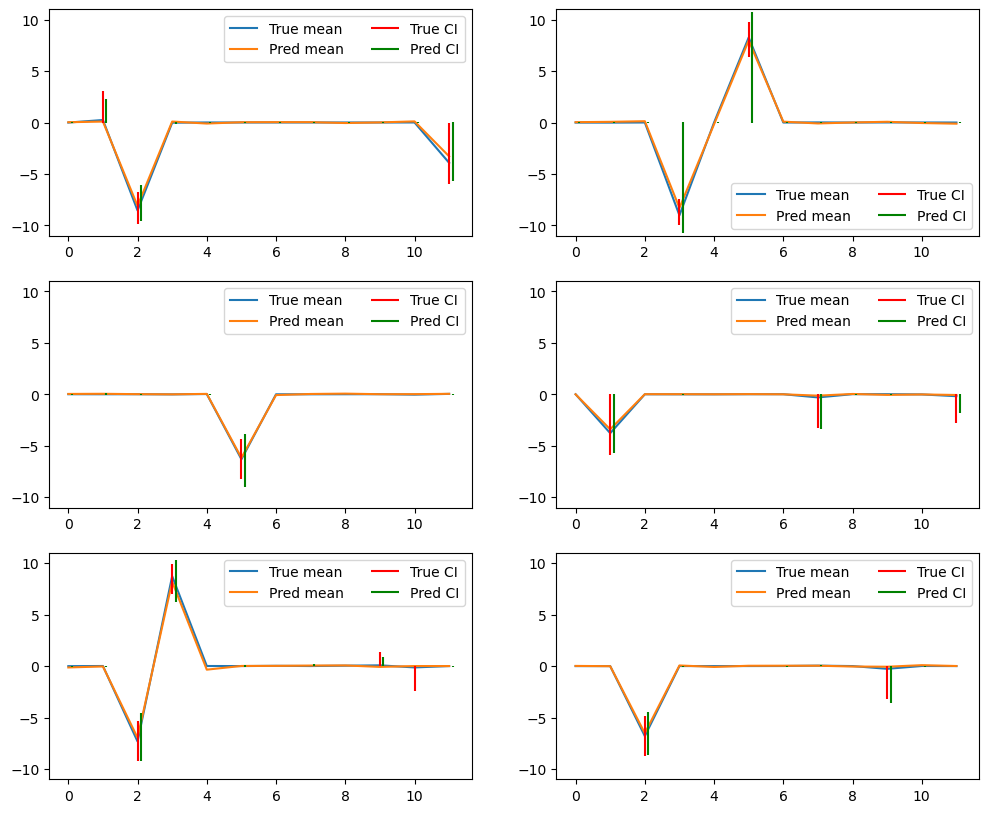

In [61]:
show_samples(12)

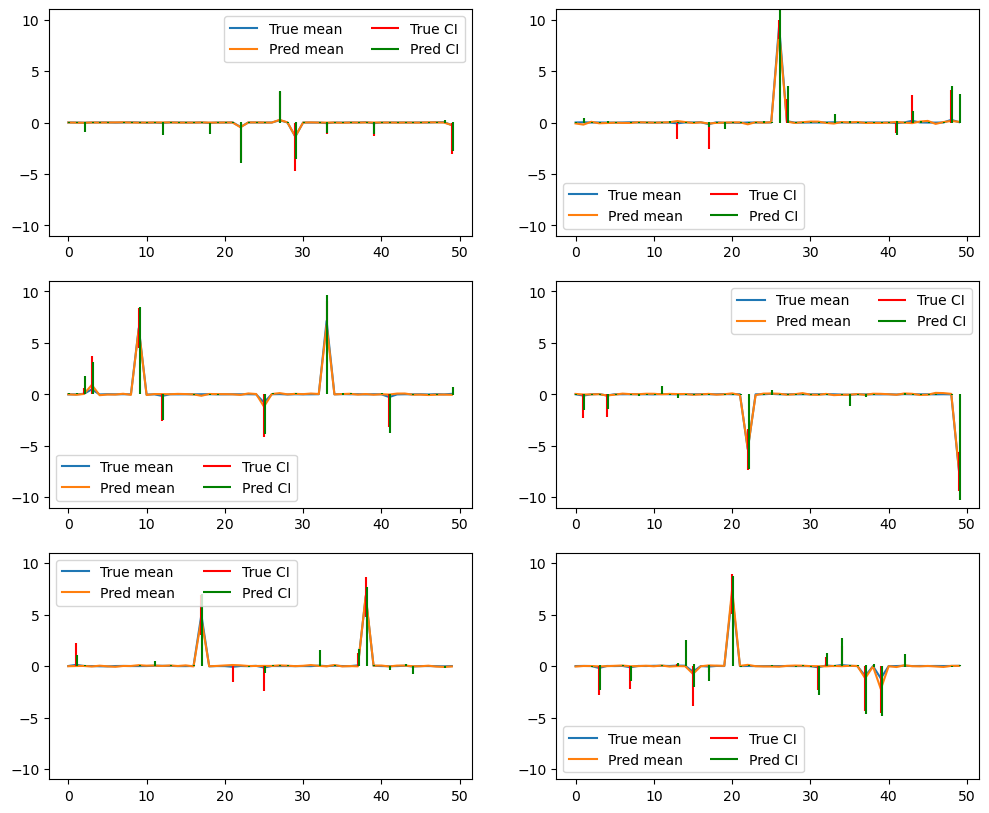

In [62]:
show_samples(50)